# Business Metrics Analysis

## Project Description

Despite significant investments in advertising, the company has been experiencing losses over the past few months, particularly from the entertainment application Procrastinate Pro+.

The project's objective is to identify the reasons behind these losses and assist the company in turning a profit. There is data available on users who were attracted from May 1 to October 27, 2019, including:

- Server logs with information on their visits.
- Data exports of their purchases during this period.
- Advertising expenses.

Within the project, the following will be studied:
- where users come from and what devices they use,
- how much it costs to attract users from different advertising channels;
- how much money each customer brings,
- when customer acquisition costs pay off,
- what factors hinder customer acquisition.

My research will go in four stages:
- Data overview
- The functions for calculating and analyzing LTV, ROI, Retention, and Conversion
- Exploratory data analysis
- Overall concolusion

## 1. Data Overview

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
visits = pd.read_csv('visits_info_short.csv') # the dataset containing information about user visits
visits.columns = visits.columns.str.lower()
visits = visits.rename(columns={'user id': 'user_id', 'session start' :'session_start', 'session end': 'session_end'})
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.head(5)

user_id         region   device  channel       session_start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic 2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop 2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic 2019-05-01 03:33:35   

          session_end  
0 2019-05-01 02:45:01  
1 2019-05-01 04:47:35  
2 2019-05-01 15:32:08  
3 2019-05-01 00:54:25  
4 2019-05-01 03:57:40

In [3]:
visits.info()
print('Number of duplicates: ', visits['user_id'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
Number of duplicates:  159893


In [4]:
orders = pd.read_csv('orders_info_short.csv') # the dataset containing information about user orders
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id': 'user_id', 'event dt' :'event_dt'})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.head(5)

user_id            event_dt  revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99

In [5]:
orders.info()
print('Number of duplicates: ', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
Number of duplicates:  0


In [6]:
costs = pd.read_csv('costs_info_short.csv') # the dataset containing information about advertising 
                                            # campaign expenses by advertising sources

costs.columns = costs.columns.str.lower()

costs['dt'] = pd.to_datetime(costs['dt'])
costs.head(5)

dt   channel  costs
0 2019-05-01  FaceBoom  113.3
1 2019-05-02  FaceBoom   78.1
2 2019-05-03  FaceBoom   85.8
3 2019-05-04  FaceBoom  136.4
4 2019-05-05  FaceBoom  122.1

In [7]:
costs.info()
print('Number of duplicates: ', costs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       1800 non-null   datetime64[ns]
 1   channel  1800 non-null   object        
 2   costs    1800 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB
Number of duplicates:  0


In [8]:
print('List of channels: ', costs['channel'].unique())

List of channels:  ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']


In [9]:
print('List of advertising sources: ', visits['channel'].unique())

List of advertising sources:  ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


## 2. Functions to calculate and alnalyze LTV, ROI, retention, and conversion

Functions to calculate metric values:

- `get_profiles()` - for creating user profiles,
- `get_retention()` - for calculating Retention Rate,
- `get_conversion()` - for calculating conversion,
- `get_ltv()` - for calculating LTV.

Functions to build graphs:

- `filter_data()` - for smoothing data,
- `plot_retention()` - for building a Retention Rate graph,
- `plot_conversion()` - for building a conversion graph,
- `plot_ltv_roi` - for visualizing LTV and ROI.

### 2.1. The function for creating user profiles

In [10]:
def get_profiles(sessions, orders, ad_costs):

# the first visit parameters are found.
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
# for cohort analysis, I will determine the date of the first visit and the first day of the month when this visit occurred
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
   
    
# Adding the feature of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
   

# Calculating the number of unique users with the same source and acquisition date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

# Combining advertising expenses and the number of attracted users.
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

# Dividing advertising expenses by the number of acquired users
# Saving the results in the acquisition_cost (CAC) column
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']


# Adding customer acquisition cost to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

# The cost of acquiring organic users is zero.
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles
 

### 2.2. The function for smoothing data

In [11]:
def filter_data(df, window):
    # apply moving average to each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### 2.3. The function for calculating LTV

In [12]:
def get_ltv(    
    profiles,  # Step 1. Obtain user profiles and purchase data
    purchases,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False,
):

    # excluding users who did not "survive" until the analysis horizon.
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_ts <= @last_suitable_acquisition_date')

   # Step 2. Add purchase data to profiles

    result_raw = result_raw.merge(
        
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

   # Step 3. Calculate the user lifetime for each purchase.
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # Group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

   # function for grouping the table by desired attributes
    def group_by_dimensions(df, dims, horizon_days):

    # Step 4. Build a revenue table, creating a "triangular" table 
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  
            aggfunc='sum',
        )

    # Step 5. Calculate the cumulative revenue.
        result = result.fillna(0).cumsum(axis=1)

    # Step 6. Calculate сohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

    # Step 7. Merge the cohort sizes and revenue table.
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
            
    # Step 8. The calculation of LTV
        # dividing each 'cell' in the row by cohort size
        result = result.div(result['cohort_size'], axis=0)
        # excluding all lifetimes exceeding the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes
        # Save user data and CAC values to a DataFrame, 
        # adding parameters from dimensions.
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # сalculating the average CAC based on dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calculating ROI: divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # removing rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # "Restoring cohort sizes in the table ROI 
        roi['cohort_size'] = cohort_sizes

        # adding CAC to the table ROI
        roi['cac'] = cac['cac']

        # in the final table, the cohort sizes, CAC, and ROI in lifetimes that do not exceed the analysis horizon are retained
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # The tables LTV and ROI are returned.
        return result, roi

    # Getting tables LTV and ROI 
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # removing 'cohort' from dimensions for dynamic tables
    if 'cohort' in dimensions:
        dimensions = []

    # getting tables with dynamics of LTV and ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,  # ROI dynamics table
    )

### 2.4. The function for calculating Retention Rate

In [13]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # the addition of the "payer" column to the passed "dimensions" list
    dimensions = ['payer'] + dimensions

    # excluding users who did not 'survive' until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('first_ts <= @last_suitable_acquisition_date')
    
    sessions_raw = sessions.query('session_start <= @last_suitable_acquisition_date')
    # The process of gathering "raw" data for churn rate calculation.
    result_raw = result_raw.merge(
        sessions_raw[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days 
    
    # the function for grouping a table by desired features.
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # obtaining a retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # obtaining a retention dynamics table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # the return of both tables and raw data
    return result_raw, result_grouped, result_in_time   
    

### 2.5. The function for calculating Сonversion

In [14]:
def get_conversion(   
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Excluding users who did not 'survive' until the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Determining the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # The collection of "raw" data for calculating retention
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # The function for grouping a table by desired attributes
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
    # Dividing each 'cell' in a row by the cohort size and calculating the conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # Obtaining the Conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # Obtaining a Conversion Rate Dynamics Table
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # The return of general tables and raw data
    return result_raw, result_grouped, result_in_time 

### 2.6. The function for building a Retention Rate graph

In [15]:
# the function for Retention Visualization

def plot_retention(retention, retention_history, horizon, window=7):

    # Grid size for plots
    plt.figure(figsize=(15, 10))

    # Excluding cohort sizes and day one retention
    retention = retention.drop(columns=['cohort_size', 0])
    # In the table of dynamics, only the required lifetime remains
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # If only the "payer" is retained in the retention table's indexes, a second feature, "cohort," is added
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # In the chart table, there are two columns and two rows, totaling four cells. 
   
    # In the first cell, retention curves for paying users are plotted.
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime') 
    plt.title('The retention of paying users')

    # In the second cell, retention curves for non-payers are plotted.
    # The vertical axis corresponds to the graph from the first cell.
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('The retention of non-paying users')

    # In the third cell - dynamics of retaining paying users.
    ax3 = plt.subplot(2, 2, 3)
    # Getting column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # Data Filtering and Plotting
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of recruitment')
    plt.title(
        'The dynamics of retaining paying users on the {} day'.format(
            horizon
        )
    )

    # In the fourth cell - dynamics of retaining non-payers.
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # Data Filtering and Plotting
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of recruitment')
    plt.title(
        'The dynamics of retaining non-paying users on the {} day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### 2.7. The function for building a Conversion graph

In [16]:
# Function for visualizing Сonversion rate

def plot_conversion(conversion, conversion_history, horizon, window=7):
    # grid size for plots
    plt.figure(figsize=(15, 5))

    # Exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # Keep only the desired lifetime in the conversion history table
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # The first plot — conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User Conversion')

    # The second plot — The dynamics of conversion.
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # The columns of the pivot table will be all the index columns except for the date.
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('User conversion dynamics on day {}'.format(horizon))

    plt.tight_layout()
    plt.show() 

### 2.8. The function for building of LTV and ROI graph

In [17]:
# graph for visualizing LTV and ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # grid size for plots
    plt.figure(figsize=(20, 10))

    # Remove cohort sizes from the ltv table
    ltv = ltv.drop(columns=['cohort_size'])
    # Keep only the required lifetime value data in the ltv dynamics table.
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # Store customer acquisition cost in a separate dataframe.
    cac_history = roi_history[['cac']]

    # Exclude cohort sizes and CAC from the ROI table.
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    # Keep only the required lifetime value (ltv) data in the ROI dynamics table
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # The first plot displays LTV curves.
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # The second plot shows the dynamics of LTV
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    # The columns of the pivot table will become all the index columns except for the date.
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('The Dynamics of LTV of users on the {}-th day'.format(horizon))

    # Third graph - CAC dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # The columns of the pivot table will include all index columns except for the date.
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of acquisition')
    plt.title('The Dynamics of CAC')

    # The fourth plot represents ROI curves.
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Break-even Level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # Fifth graph - ROI dynamics
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # The columns of the pivot table will be all the index columns except for the date
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Break-even Level')
    plt.xlabel('Date of acquisition')
    plt.title('The Dynamics of ROI for users on day {}'.format(horizon))

    plt.tight_layout()
    plt.show() 

## 3. Exploratory Data Analysis

#### 3.1. User profiles. Minimum and maximum user acquisition dates.

In [18]:
profiles = get_profiles(visits, orders, costs) # User profiles
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
min_date = profiles['first_ts'].dt.date.min() 
max_date = profiles['first_ts'].dt.date.max()
print('Minimum user acquisition date:', min_date)
print('Maximum user acquisition date:', max_date)

Minimum user acquisition date: 2019-05-01
Maximum user acquisition date: 2019-10-27


In [19]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  datetime64[ns]
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


In [20]:
profiles.head()

user_id            first_ts     channel  device         region         dt  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States 2019-05-07   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States 2019-07-09   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France 2019-10-01   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany 2019-08-22   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States 2019-10-02   

       month  payer  acquisition_cost  
0 2019-05-01   True          1.088172  
1 2019-07-01  False          1.107237  
2 2019-10-01  False          0.000000  
3 2019-08-01  False          0.988235  
4 2019-10-01  False          0.230769

In [21]:
print(len(profiles['user_id'].unique()))


150008


**Conclusion:**
Profiles of 150,008 users have been created, including user ID, session start date, referral source ID, user country, and user device type. The information is provided for the period from 2019-05-01 to 2019-10-27.

#### 3.2. The countries where users access the app and the country with the highest number of paying users

In [22]:
print('The countries from which users access the application:', profiles['region'].unique())


The countries from which users access the application: ['United States' 'France' 'Germany' 'UK']


In [23]:
orders_max = pd.DataFrame()
orders_max['count_users'] = profiles.groupby('region')['user_id'].count()
orders_max['count_users_payer'] = profiles.query('payer == True').groupby('region')['user_id'].count()
orders_max['share'] = round(orders_max['count_users_payer'] / orders_max['count_users'] *100, 2)
orders_max.sort_values(by=['share'], ascending=False)

count_users  count_users_payer  share
region                                              
United States       100002               6902   6.90
Germany              14981                616   4.11
UK                   17575                700   3.98
France               17450                663   3.80

In [24]:
orders_max_country = orders_max.query('count_users_payer == count_users_payer.max()').reset_index() 
print('The country with the highest number of paying users:', orders_max_country['region'].iloc[0])

The country with the highest number of paying users: United States


In [25]:
print('The maximum share of paying users:', orders_max['share'].max(), '%')

The maximum share of paying users: 6.9 %


**Conclusion:**
Among the countries where users access the application (France, Germany, the United Kingdom, and the United States), the application is most popular in the United States. Consequently, the largest number of paying users (6902 people) is also in the United States. At the same time, the share of paying users is 6.9% of the total number of users in the United States.

#### 3.3. Devices used by customers and devices preferred by paying users. 

In [26]:
print('Devices used by clients:', profiles['device'].unique())


Devices used by clients: ['Mac' 'iPhone' 'PC' 'Android']


In [27]:
device_max = pd.DataFrame()
device_max['count_users'] = profiles.groupby('device')['user_id'].count()
device_max['count_users_payer'] = profiles.query('payer == True').groupby('device')['user_id'].count()
# The share of paying users in the total number of users by devices.
device_max['share'] = round(device_max['count_users_payer'] / device_max['count_users'] *100, 2)
device_max.sort_values(by=['share'], ascending=False).reset_index()

device  count_users  count_users_payer  share
0      Mac        30042               1912   6.36
1   iPhone        54479               3382   6.21
2  Android        35032               2050   5.85
3       PC        30455               1537   5.05

**Conclusion:** Devices used by all customers and devices preferred by paying users: 'Android' 'iPhone' 'Mac' 'PC'. The most popular among paying users are Mac and iPhone (6.36% and 6.21% of the total number of users, respectively).

#### 3.4. Advertising sources for acquisition and identify the channels that brought the most paying users.

In [28]:
print('Advertising user acquisition sources:', profiles['channel'].unique())


Advertising user acquisition sources: ['FaceBoom' 'organic' 'AdNonSense' 'YRabbit' 'MediaTornado'
 'RocketSuperAds' 'LeapBob' 'TipTop' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [29]:
channel_max = pd.DataFrame()
channel_max['count_users'] = profiles.groupby('channel')['user_id'].count()
channel_max['count_users_payer'] = profiles.query('payer == True').groupby('channel')['user_id'].count()

# Share of paying users in the total number of users by devices
channel_max['share_payer'] = round(channel_max['count_users_payer'] / channel_max['count_users'] *100, 2)
channel_max.sort_values(by=['share_payer'], ascending=False).reset_index()

channel  count_users  count_users_payer  share_payer
0             FaceBoom        29144               3557        12.20
1           AdNonSense         3880                440        11.34
2       lambdaMediaAds         2149                225        10.47
3               TipTop        19561               1878         9.60
4       RocketSuperAds         4448                352         7.91
5       WahooNetBanner         8553                453         5.30
6              YRabbit         4312                165         3.83
7         MediaTornado         4364                156         3.57
8              LeapBob         8553                262         3.06
9   OppleCreativeMedia         8605                233         2.71
10             organic        56439               1160         2.06

In [30]:
channel_max = channel_max.sort_values(by=['count_users'], ascending=False).reset_index()
channel_max[0:3]

channel  count_users  count_users_payer  share_payer
0   organic        56439               1160         2.06
1  FaceBoom        29144               3557        12.20
2    TipTop        19561               1878         9.60

**Conclusion:**
Advertising sources attracting paying users: FaceBoom, RocketSuperAds, TipTop, organic, MediaTornado, YRabbit, AdNonSense, WahooNetBanner, lambdaMediaAds, LeapBob, OppleCreativeMedia. The channels through which the most paying users came are FaceBoom, AdNonSense, and lambdaMediaAds. They account for 12.20%, 11.34%, and 10.47% of the total number of users for these channels, respectively. At the same time, the leaders among the channels in terms of the number of users are organic, FaceBoom, and TipTop.

#### 3.5. Marketing

#### Calculation of the total marketing expenses

In [31]:
total_sum = costs['costs'].sum()
print('The total marketing expenses:', round(total_sum, 2))

The total marketing expenses: 105497.3


#### Distribution of expenses across advertising sources

In [32]:
total_sum = costs.groupby(by=['channel'])['costs'].sum().reset_index().sort_values(by='costs', ascending=False)


In [33]:
total_sum

channel     costs
6              TipTop  54751.30
1            FaceBoom  32445.60
7      WahooNetBanner   5151.00
0          AdNonSense   3911.25
4  OppleCreativeMedia   2151.25
5      RocketSuperAds   1833.00
2             LeapBob   1797.60
9      lambdaMediaAds   1557.60
3        MediaTornado    954.48
8             YRabbit    944.22

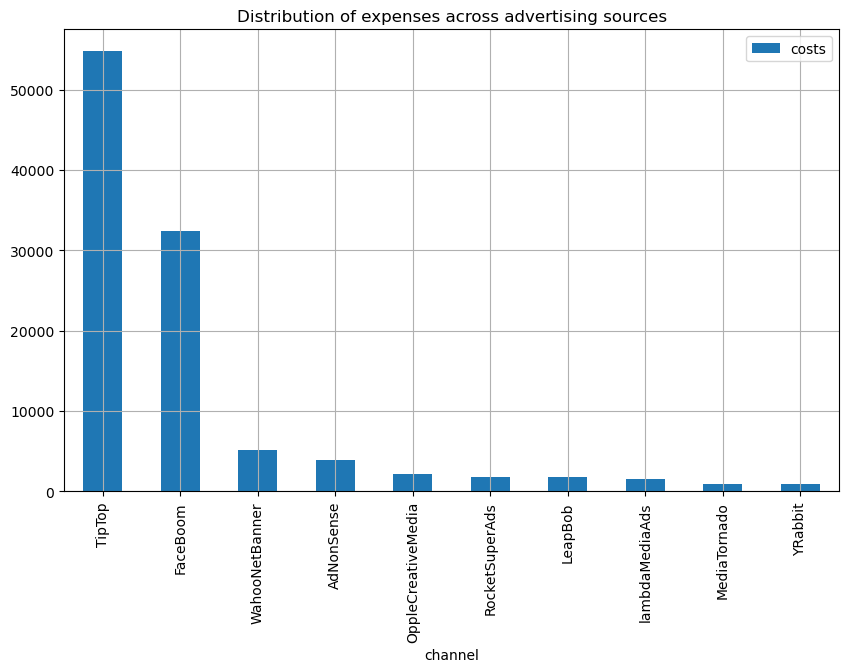

In [34]:
total_sum.plot(x='channel', y='costs', kind='bar', figsize=(10, 6), sharex=False, grid=True)
plt.title('Distribution of expenses across advertising sources')

plt.show() 


**Conclusion:**
The total marketing expenses amount to 105497.3. The primary advertising sources are TipTop - 54751.30 and FaceBoom - 32445.60. The remaining sum of expenses is distributed among the other 6 sources.

#### Visualization of the dynamics of expenditure changes over time (by weeks and months) for each source.

In [35]:
costs['dt_month'] = costs['dt'].dt.month
costs['dt_week'] = costs['dt'].dt.isocalendar().week
costs.head()

dt   channel  costs  dt_month  dt_week
0 2019-05-01  FaceBoom  113.3         5       18
1 2019-05-02  FaceBoom   78.1         5       18
2 2019-05-03  FaceBoom   85.8         5       18
3 2019-05-04  FaceBoom  136.4         5       18
4 2019-05-05  FaceBoom  122.1         5       18

In [36]:
costs_grouped_month = costs.pivot_table(index='channel', columns=['dt_month'], values = 'costs', aggfunc='sum')
costs_grouped_week = costs.pivot_table(index='channel', columns=['dt_week'], values = 'costs', aggfunc='sum')


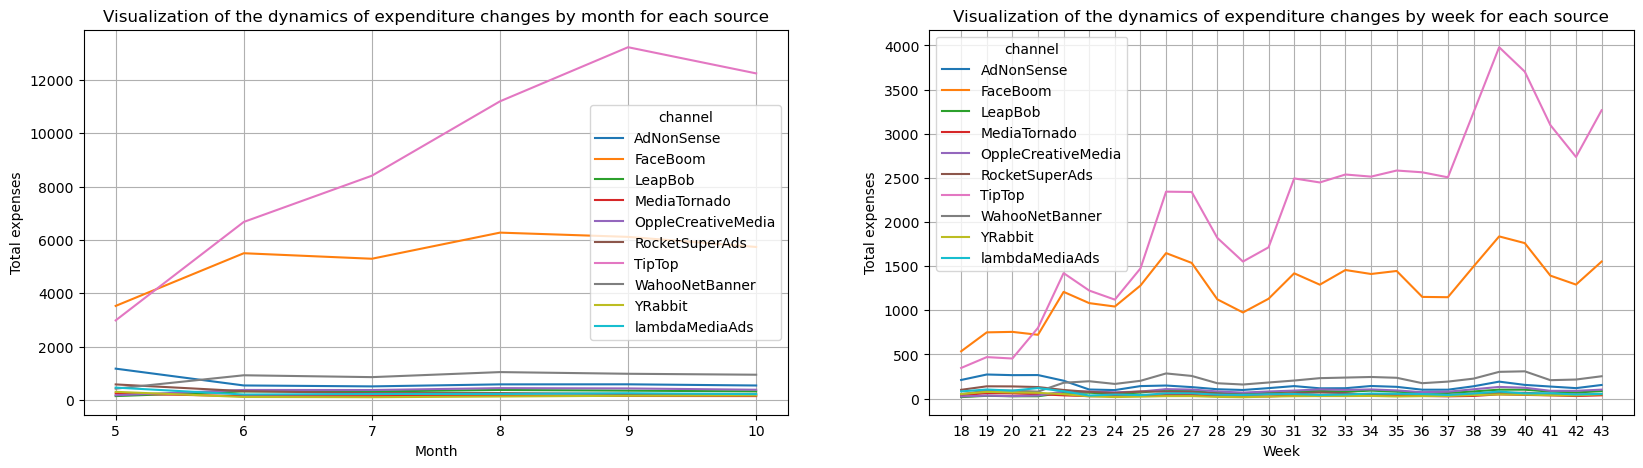

In [37]:
plt.figure(figsize=(20, 5)) 
costs_grouped_month.T.plot(
    grid=True, xticks=list(costs_grouped_month.columns.values), ax=plt.subplot(1, 2, 1)
) 
plt.title('Visualization of the dynamics of expenditure changes by month for each source')
plt.xlabel('Month')
plt.ylabel('Total expenses')

costs_grouped_week.T.plot(
    grid=True, xticks=list(costs_grouped_week.columns.values), ax=plt.subplot(1, 2, 2)
) 
plt.title('Visualization of the dynamics of expenditure changes by week for each source')
plt.xlabel('Week')
plt.ylabel('Total expenses')

plt.show() 

**Conclusion:**
Visualization of the dynamics of advertising expenses over time (weekly and monthly) for each source confirms that active advertising campaigns are conducted on the TipTop and FaceBoom channels. 

The rest of the expenditure is distributed almost evenly among the other 6 sources during the analyzed periods. 

Speaking of the dynamics of expenses, different advertising campaign strategies have been chosen for the TipTop and FaceBoom channels.

For the FaceBoom channel, advertising expenses are carried out evenly ranging from 1000 to 2000 weekly. 

For the TipTop channel, a different strategy for conducting advertising campaigns has been chosen: during the analyzed period, expenses increased and reached their maximum in September.

#### The average cost of acquiring one user (CAC) from each source

In [38]:
# the average cost of acquiring one user (CAC) from each source
new_users_mean = profiles.groupby('channel')['acquisition_cost'].mean()
new_users_mean = new_users_mean.reset_index().sort_values(by='acquisition_cost', ascending=False)
new_users_mean['acquisition_cost'] = round(new_users_mean['acquisition_cost'], 2)
new_users_mean

channel  acquisition_cost
6               TipTop              2.80
1             FaceBoom              1.11
0           AdNonSense              1.01
9       lambdaMediaAds              0.72
7       WahooNetBanner              0.60
5       RocketSuperAds              0.41
4   OppleCreativeMedia              0.25
8              YRabbit              0.22
3         MediaTornado              0.22
2              LeapBob              0.21
10             organic              0.00

**Conclusion:**
The highest average customer acquisition cost (CAC) is associated with the TipTop source, which is 2.80. FaceBoom and AdNonSense sources rank second and third in terms of CAC (1.11 and 1.01 respectively).

#### Intermediate Conclusions.

Total marketing expenses for the analyzed period amounted to 105497.3. The main advertising sources are TipTop - 54751.30 and FaceBoom - 32445.60. When it comes to the dynamics of expenses, different advertising strategies are chosen for the TipTop and FaceBoom channels. For the FaceBoom channel, advertising expenses are evenly distributed from 1000 to 2000 per week. For the TipTop channel, a different strategy of advertising campaigns is chosen: expenses increased and reached their maximum in September. The remaining sum of expenses is distributed almost evenly among the other 6 sources throughout the analyzed period.

The highest average cost of acquiring a user (CAC) is attributed to the TipTop source, which is 2.80. It's worth noting that this source only managed to attract 1878 paying users.

Second in terms of CAC is the FaceBoom source, with a CAC of 1.11. This source managed to attract 3557 paying users.

The third-highest CAC is for the AdNonSense source, with a CAC of 1.01. This source managed to attract 440 paying users.

It's worth mentioning the organic source, which attracted customers without incurring advertising expenses. At the same time, the number of its paying users amounted to 1160.

Therefore, when identifying the reasons for the low efficiency of advertising expenses, it is necessary to pay attention to the TipTop and AdNonSense channels.

### 3.6. Assessment of advertising profitability

Analysis date - November 1, 2019.
Analysis horizon - two weeks after user acquisition, as this period is specified in the business plan as the payback period.
Users from the Organic source were not included in the analysis, as their acquisition was done without advertising expenses.

#### Analysis of advertising profitability using LTV and ROI charts, as well as dynamic graphs of LTV, CAC, and ROI

In [39]:
profiles_non_org = profiles.query('channel != "organic"')


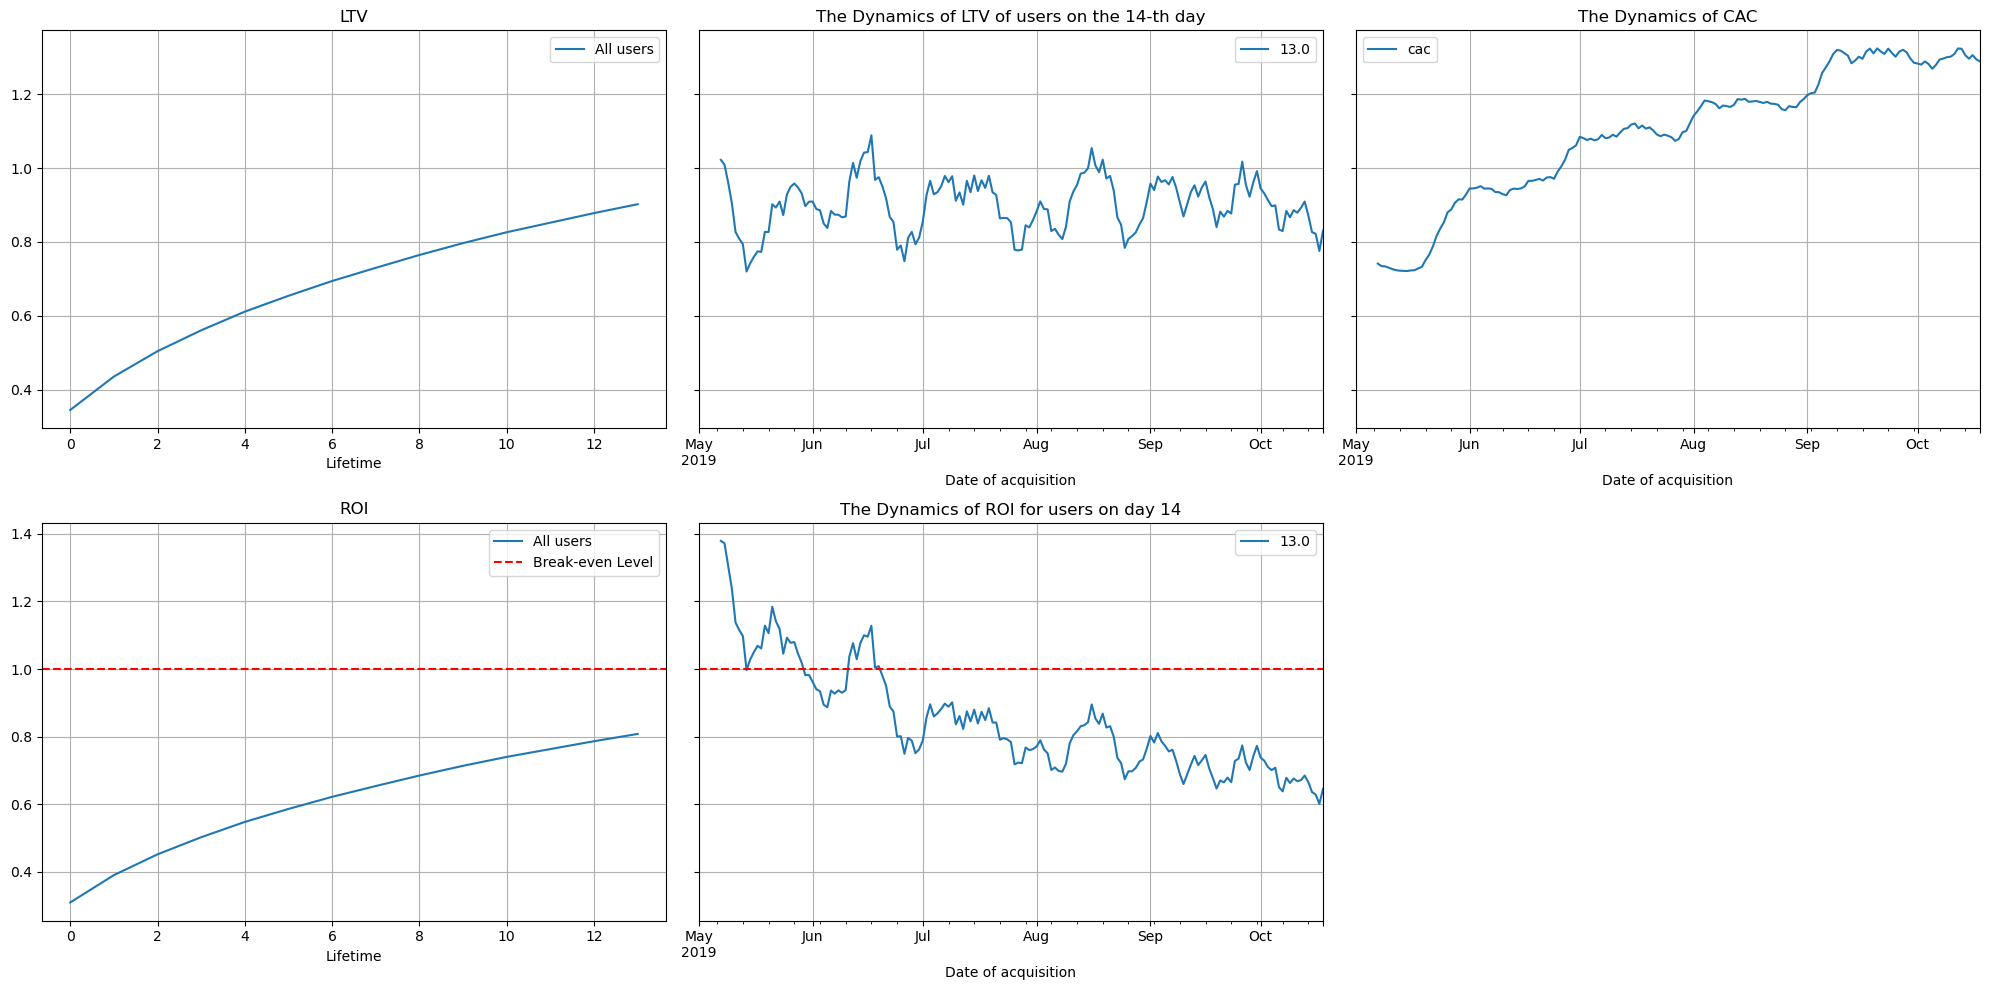

In [40]:
# Calculating LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14, dimensions=[],)

    
# Building graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

**Conclusion:**
1. LTV represents the total amount of money that, on average, a customer brings to the company through all of their purchases. From the LTV chart, it can be observed that the cumulative revenue constantly grows.
2. LTV remains at approximately the same level throughout the entire period.
3. CAC increases steadily throughout the entire period.
4. ROI did not reach the breakeven point during the entire period.
5. The overall trend of ROI showed a tendency to decrease, with advertising expenses no longer paying off by June.

####  Checking user conversion and the dynamics of its changes, including retention testing

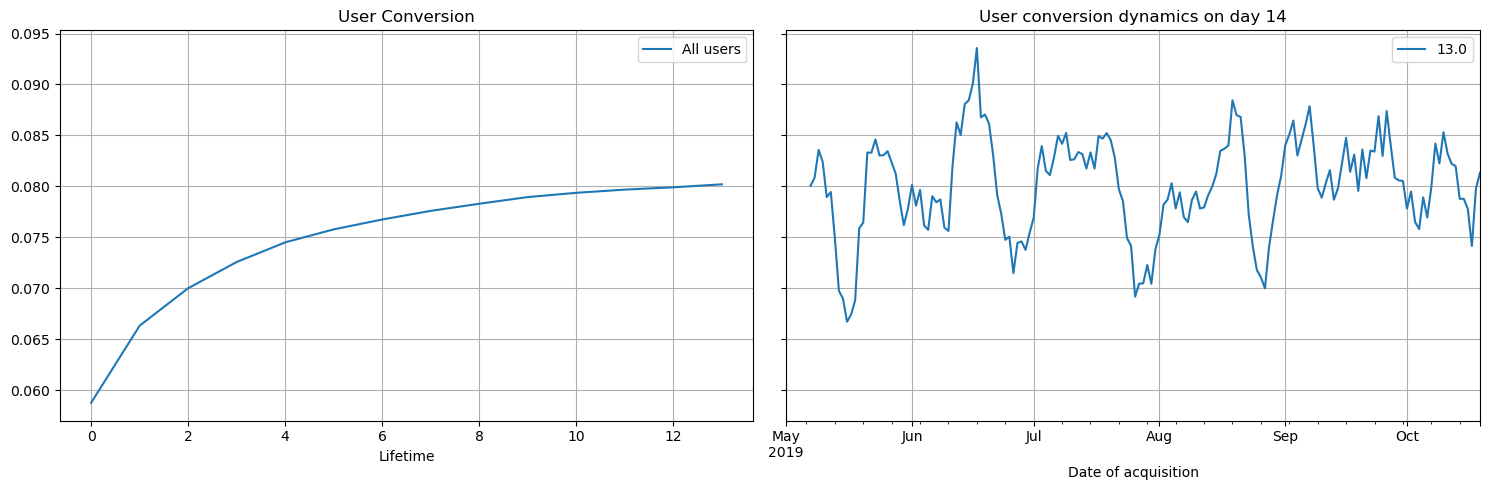

In [41]:
# Overall User Conversion
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14,)
plot_conversion(conversion_grouped, conversion_history, 14)

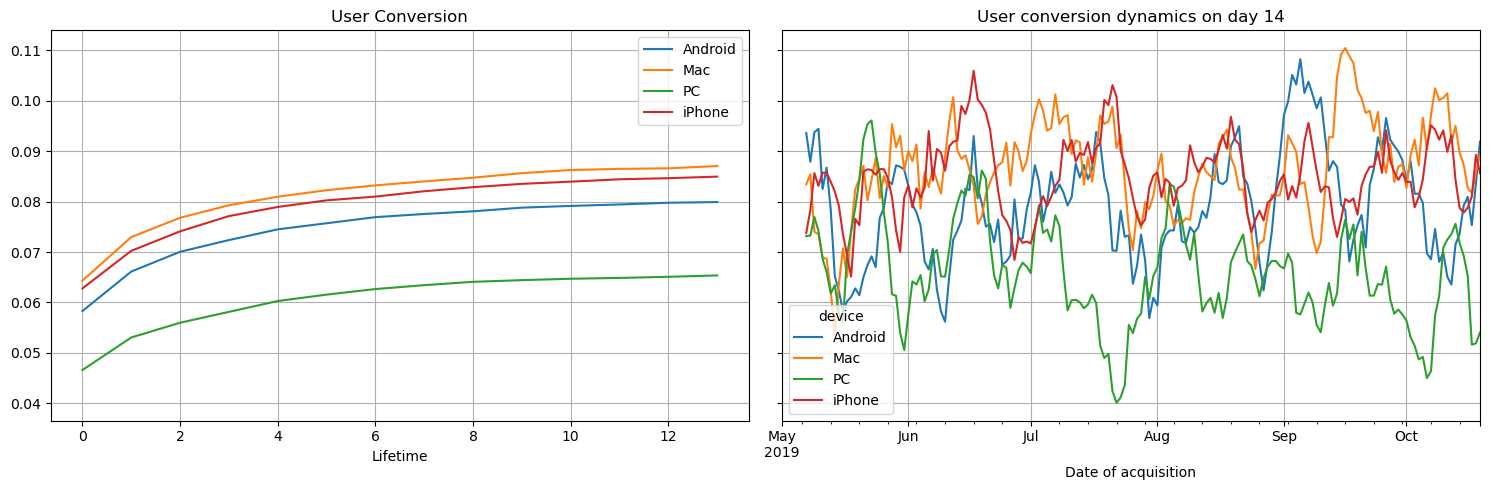

In [42]:
# User Conversion by devices
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14,dimensions=['device'],)
plot_conversion(conversion_grouped, conversion_history, 14)

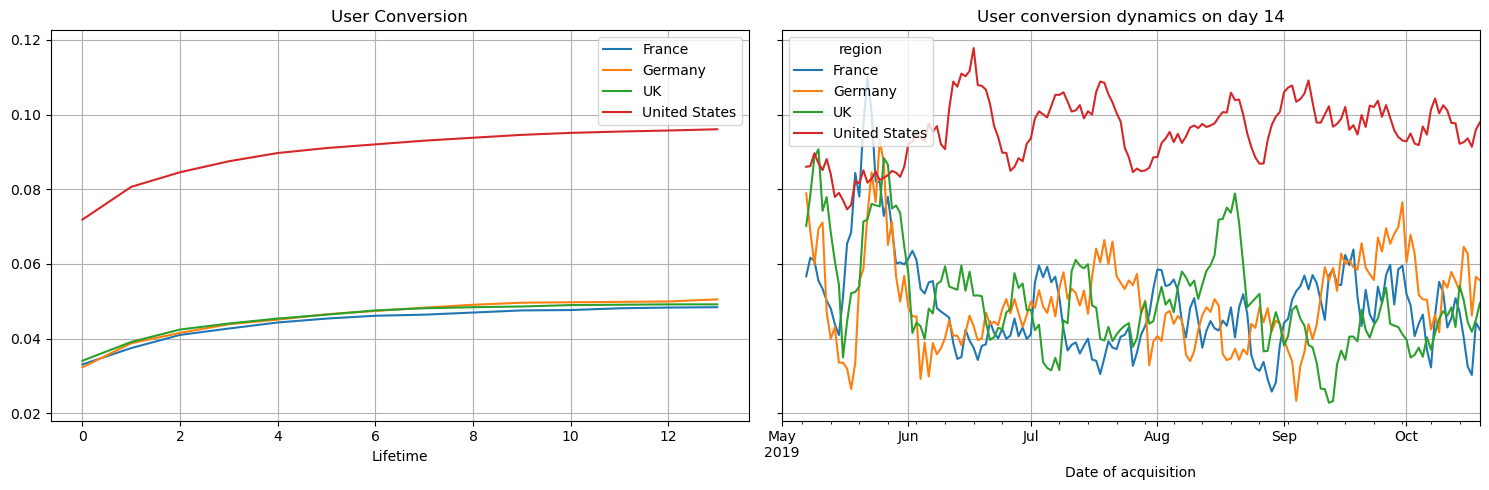

In [43]:
# User Conversion by countries
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14,dimensions=['region'],)
plot_conversion(conversion_grouped, conversion_history, 14)

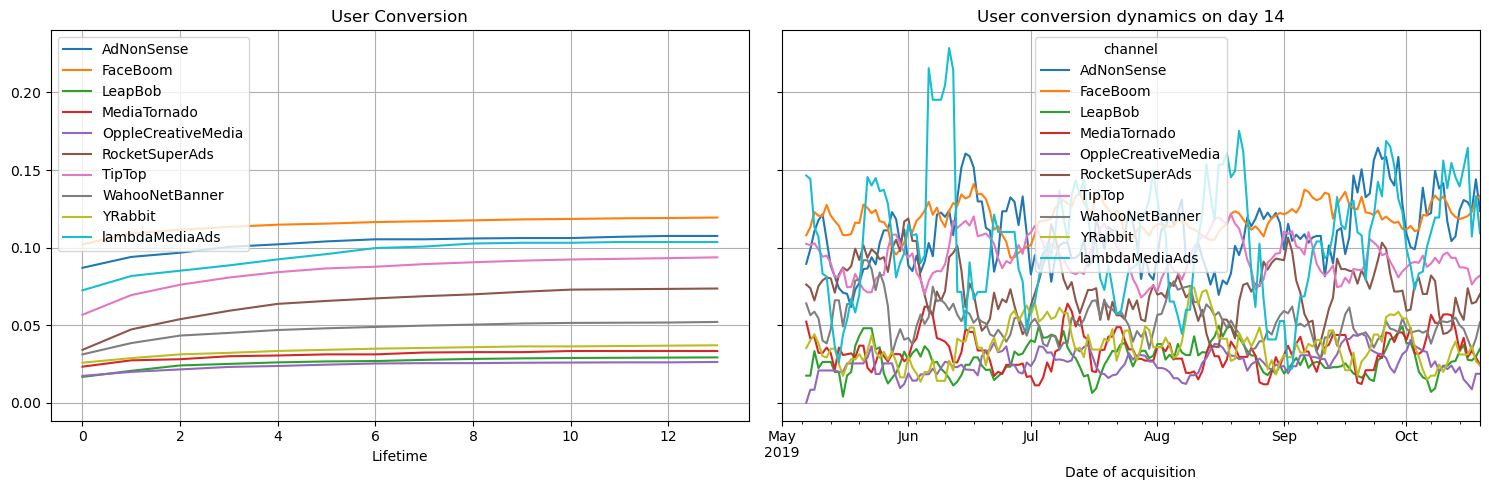

In [44]:
# User Conversion by devices by advertising sources
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14,dimensions=['channel'],)
plot_conversion(conversion_grouped, conversion_history, 14)

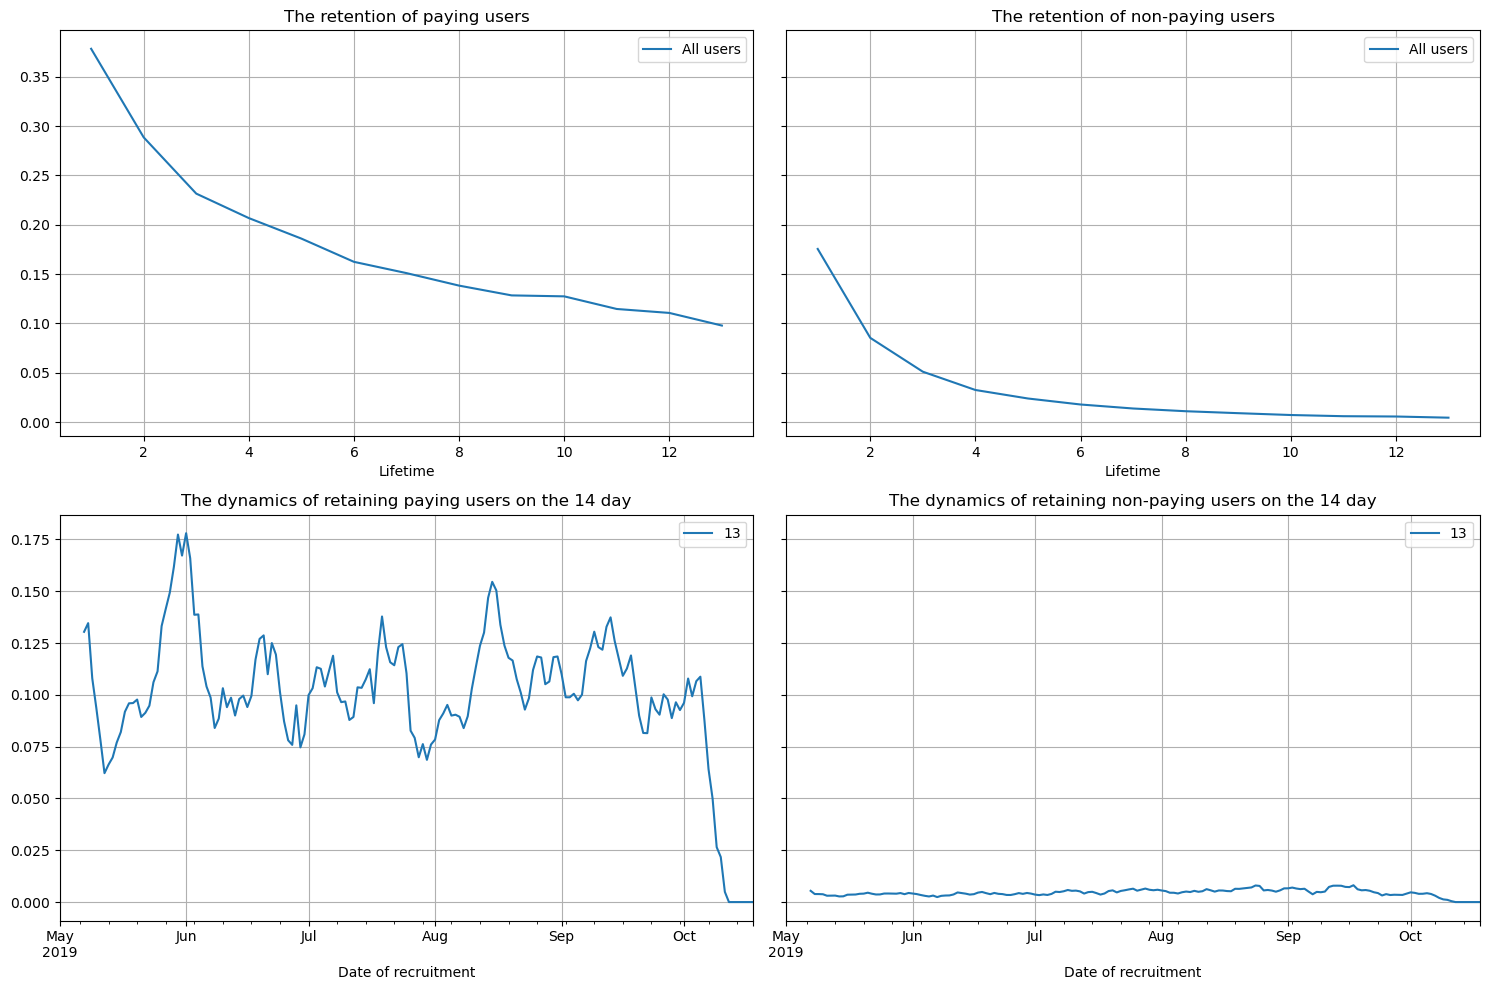

In [45]:
# Dynamics of user retention in general
retention_raw, retention_grouped, retention_history = get_retention(profiles_non_org, visits, datetime(2019,11,1).date(),14)
plot_retention(retention_grouped, retention_history, 14)

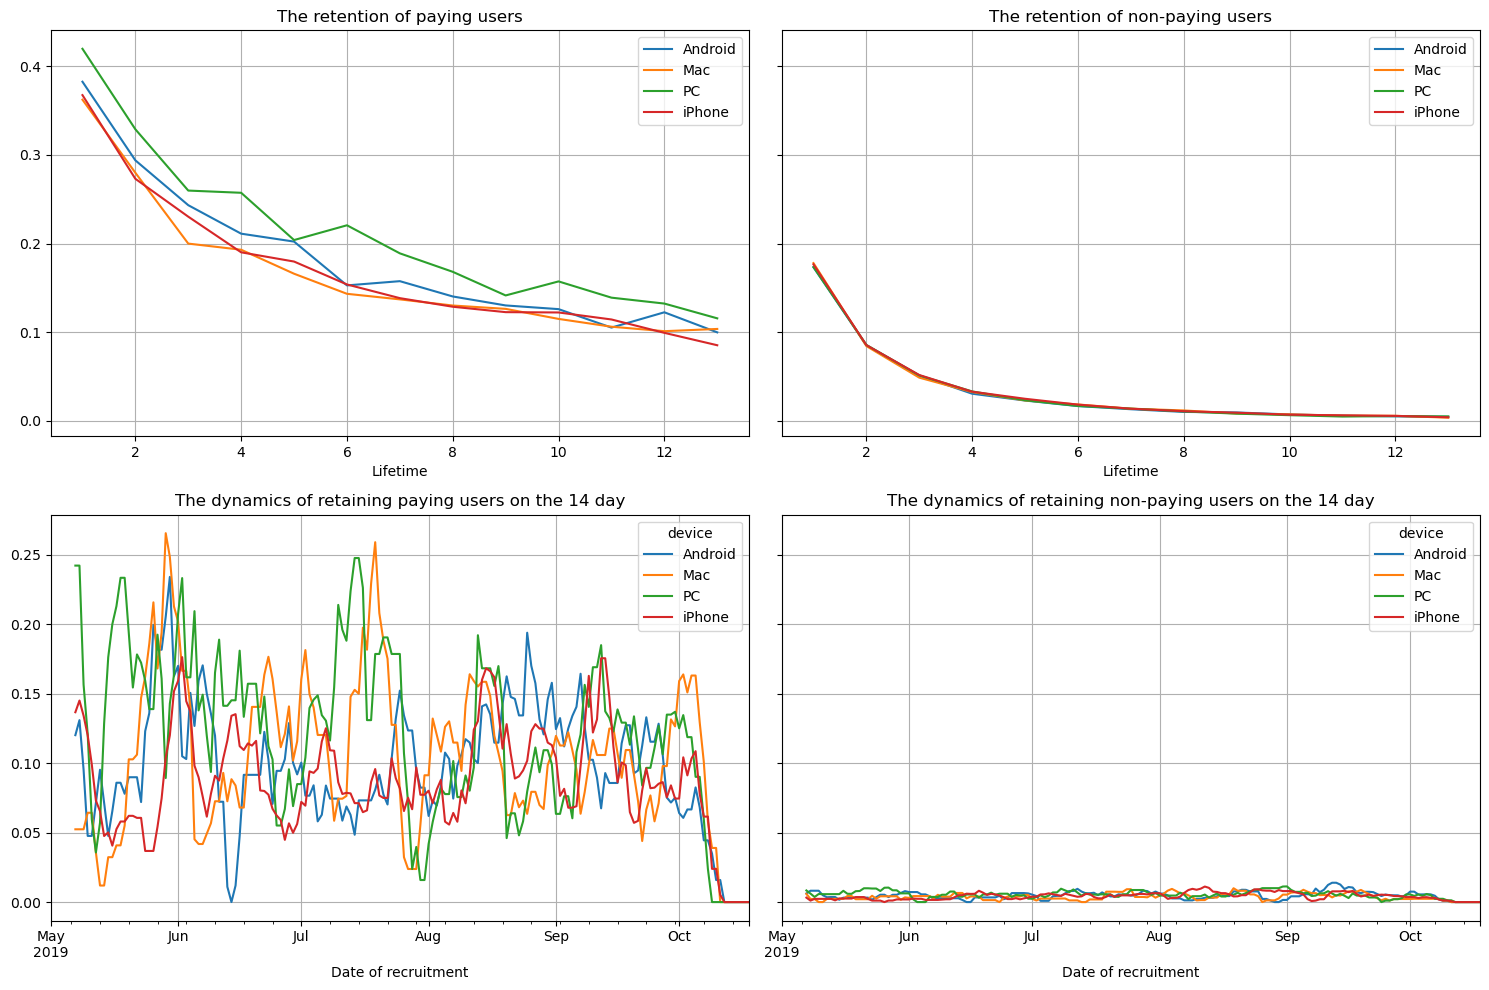

In [46]:
# The dynamics of user retention by devices
retention_raw, retention_grouped, retention_history = get_retention(profiles_non_org, visits, datetime(2019,11,1).date(), 14, 
                                                                    dimensions=['device'],)
plot_retention(retention_grouped, retention_history, 14)

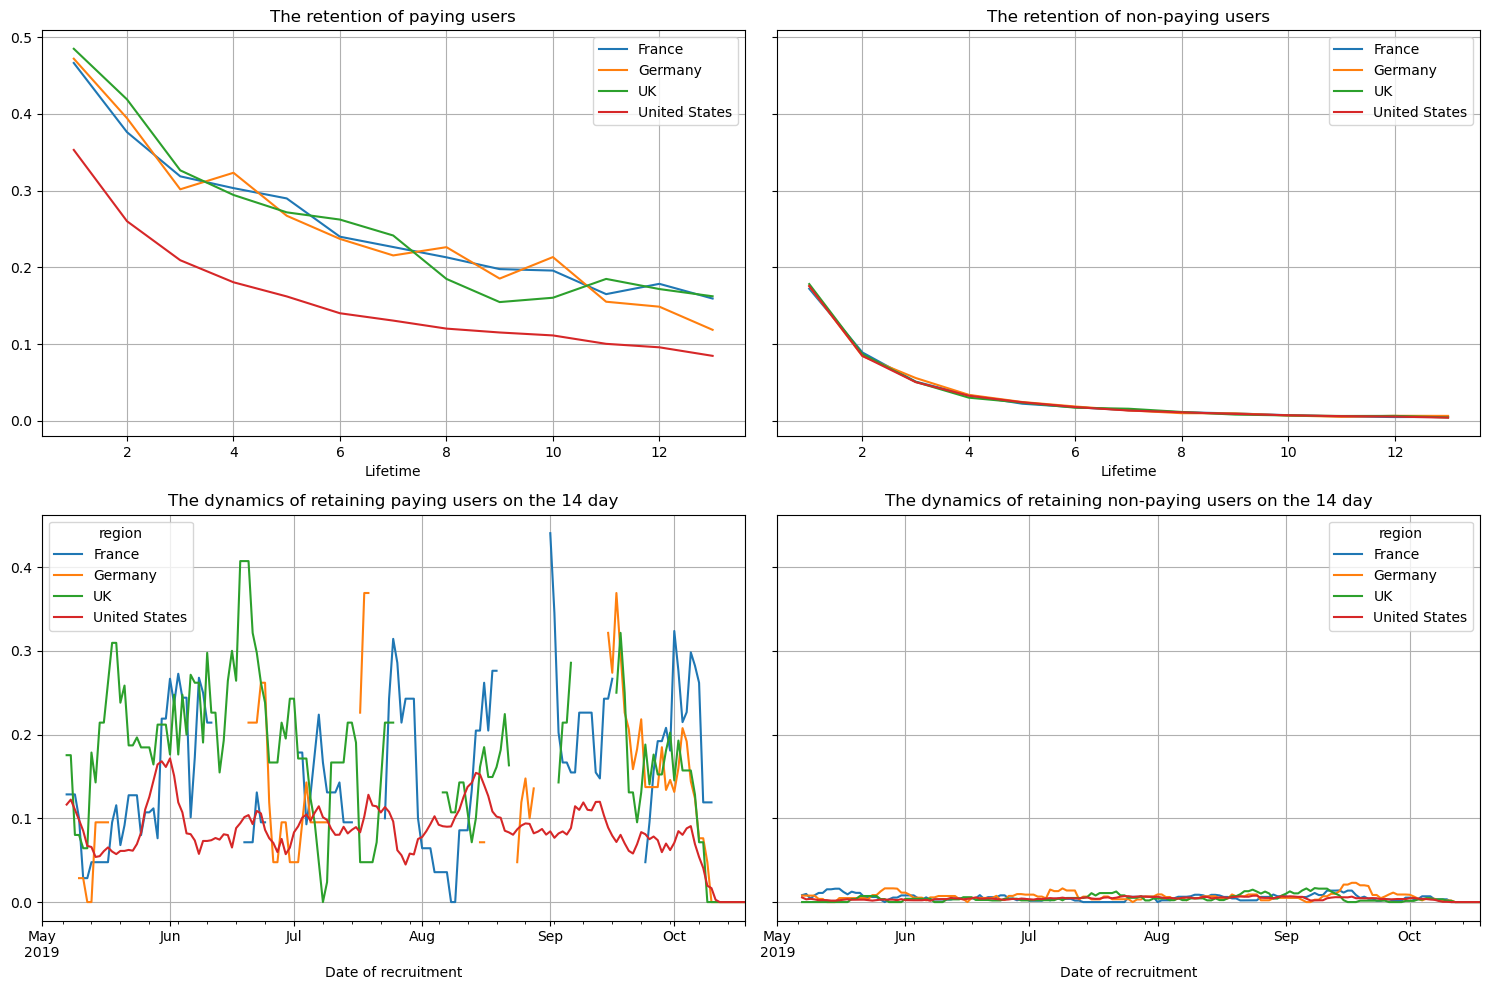

In [47]:
# The dynamics of user retention by countries
retention_raw, retention_grouped, retention_history = get_retention(profiles_non_org, visits, datetime(2019,11,1).date(), 
                                                                    14, dimensions=['region'],)
plot_retention(retention_grouped, retention_history, 14)

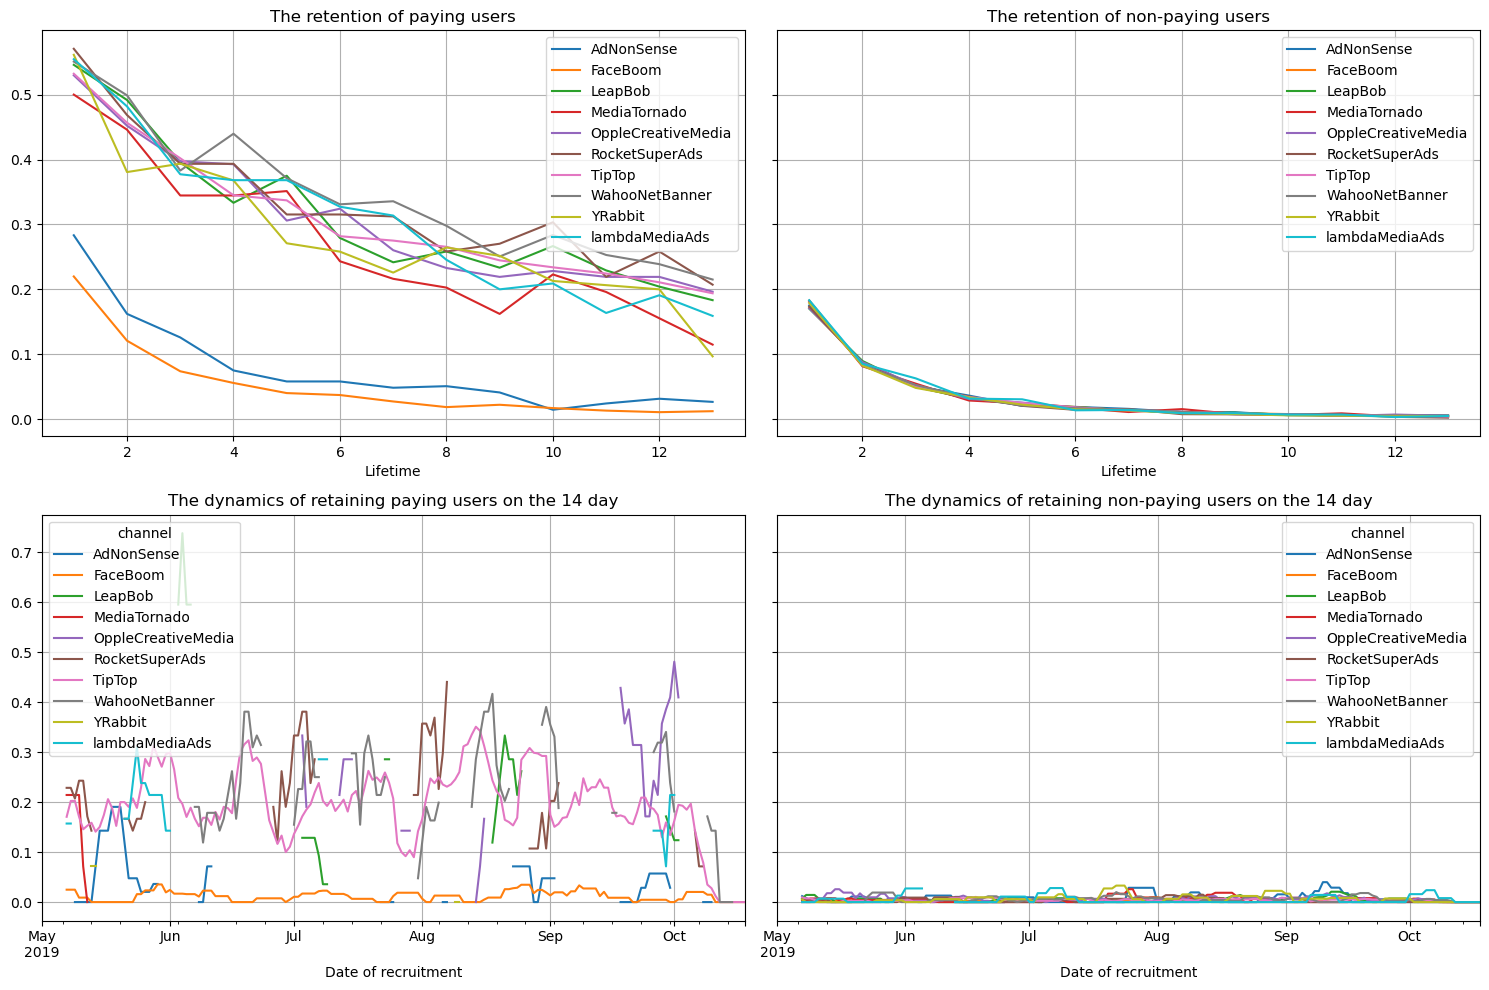

In [48]:
# The dynamics of user retention by advertising sources
retention_raw, retention_grouped, retention_history = get_retention(profiles_non_org, visits, datetime(2019,11,1).date(), 
                                                                    14, dimensions=['channel'],)
plot_retention(retention_grouped, retention_history, 14)

**Conclusion:**
User Conversion Analysis: 

The user conversion graph shows that the conversion rate gradually increased and reached its peak at the 11th week with a value of 0.08%, which is most likely the maximum. 

Furthermore, conversion does not depend on the date of the first visit or the devices used by the users. Owners of MAC and iPhone devices have a higher user conversion rate compared to other users. Users from the USA showed a significantly higher conversion rate than users from other regions. 

The graph for advertising sources indicates that the maximum conversion rate was reached in the 2nd week and then stabilized at a certain level. The highest conversion rates were observed for the channels FaceBoom, adNonSense, and LambdaMediaAds. It is noteworthy that there is a significant variation in conversion rates for the LambdaMediaAds channel depending on the date of the users' first visit.

User Retention Analysis: 

User retention graphs reflect the following general trends:
1) User retention for paying customers is significantly higher than for non-paying users.
2) User retention gradually decreases, and this trend is not dependent on the devices used.
3) Retention graphs for paying users show that the lowest retention rate is consistently observed for the advertising channel 'FaceBoom.' Additionally, there is relatively lower user retention among users from the USA.

#### Analysis of advertising profitability broken down by devices

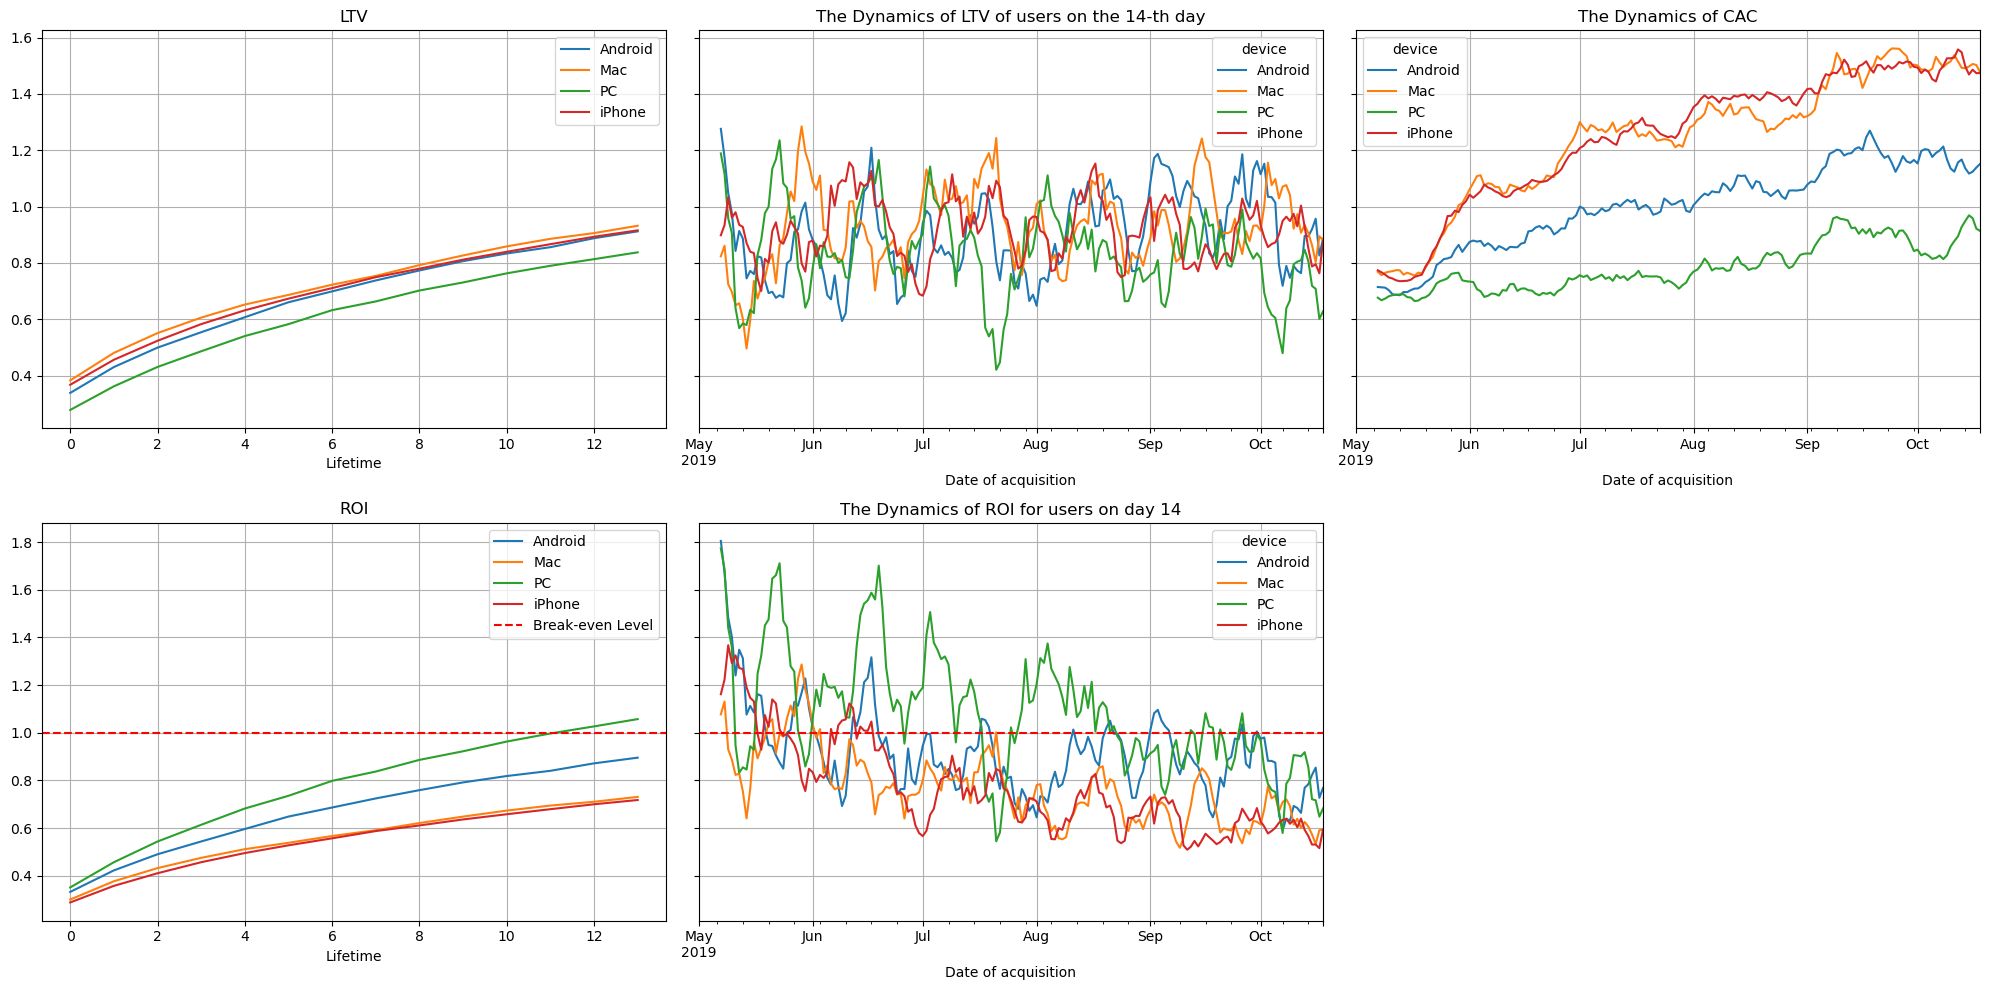

In [49]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14, dimensions=['device'],)

    
# bulding of graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

**Conclusion:** 
Over the analyzed period, the revenues generated by users showed a tendency to increase regardless of the devices. 

However, the cost of acquiring users also increased, with users on Mac and iPhone devices growing at a higher rate compared to other devices. For PC users, the cost of acquisition was significantly lower, and the return on investment was higher than for other devices. It can be said that only advertising expenses targeting PC users were profitable.

#### Analysis of advertising profitability broken down by countries

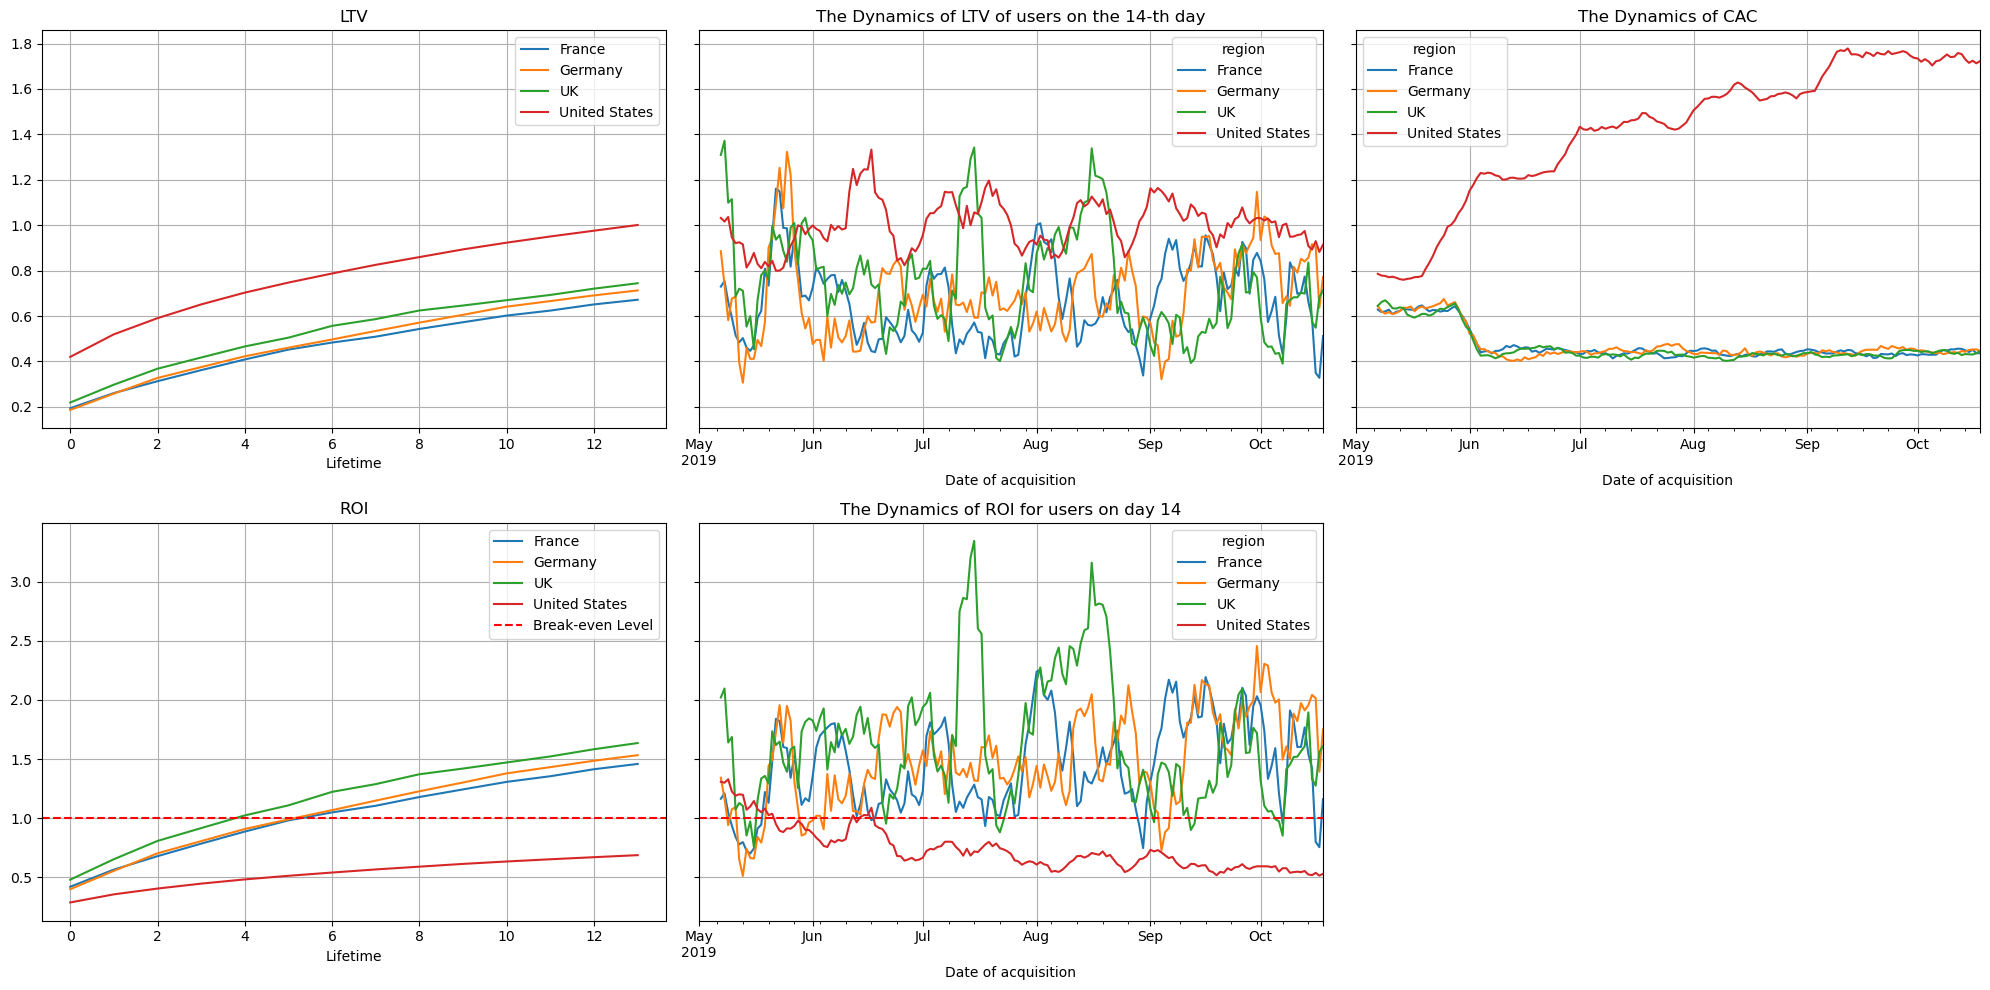

In [50]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14, dimensions=['region'],)
    
# bulding of graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

**Conclusion:**

Revenues from users in the United States were growing at a faster pace than from users in other countries; however, advertising expenses to attract them were growing at a higher rate and were not profitable in both the short and long term. 

Advertising expenses in other countries started to pay off after the 6th day of the user's first visit and showed good profitability in the long term.

#### Analysis of advertising ROI with a breakdown by advertising channels

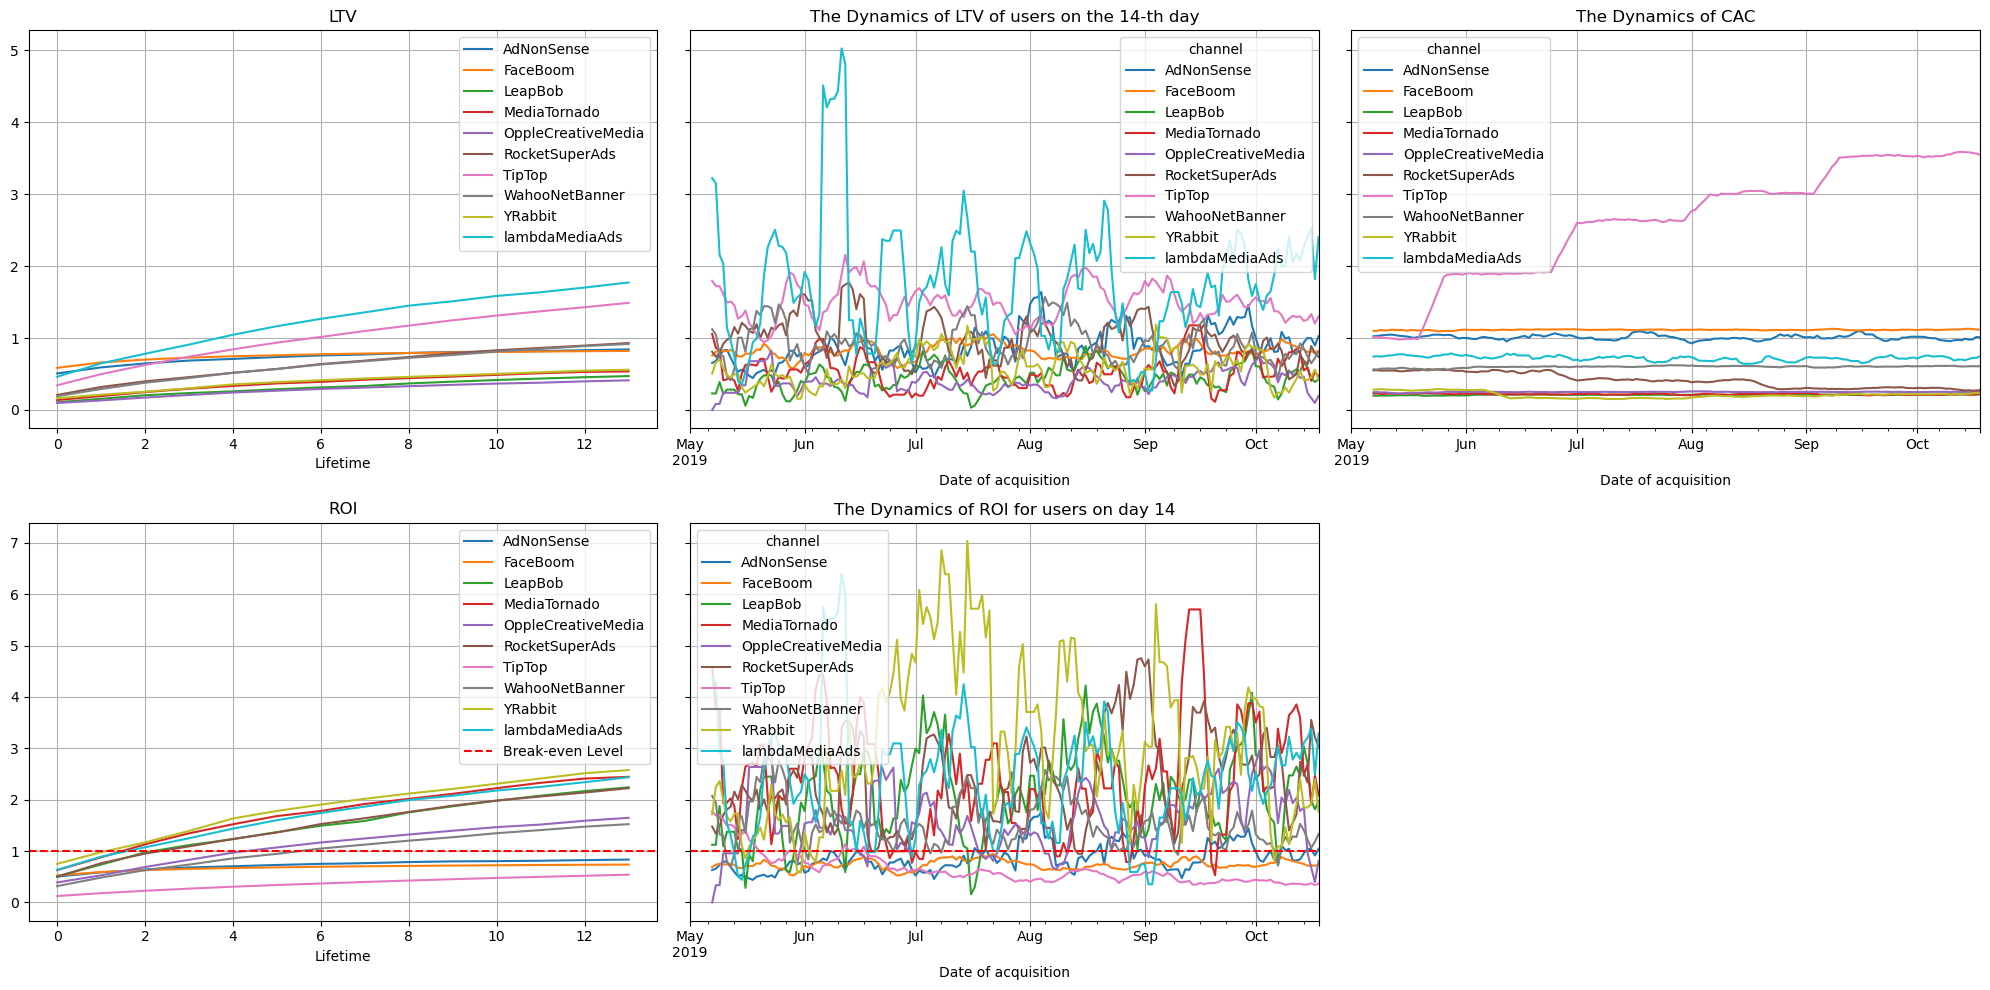

In [51]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_non_org, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'],)

    
# building of graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

In [52]:
profiles_non_org_usa = profiles_non_org.query('region != "USA"') # only for the USA

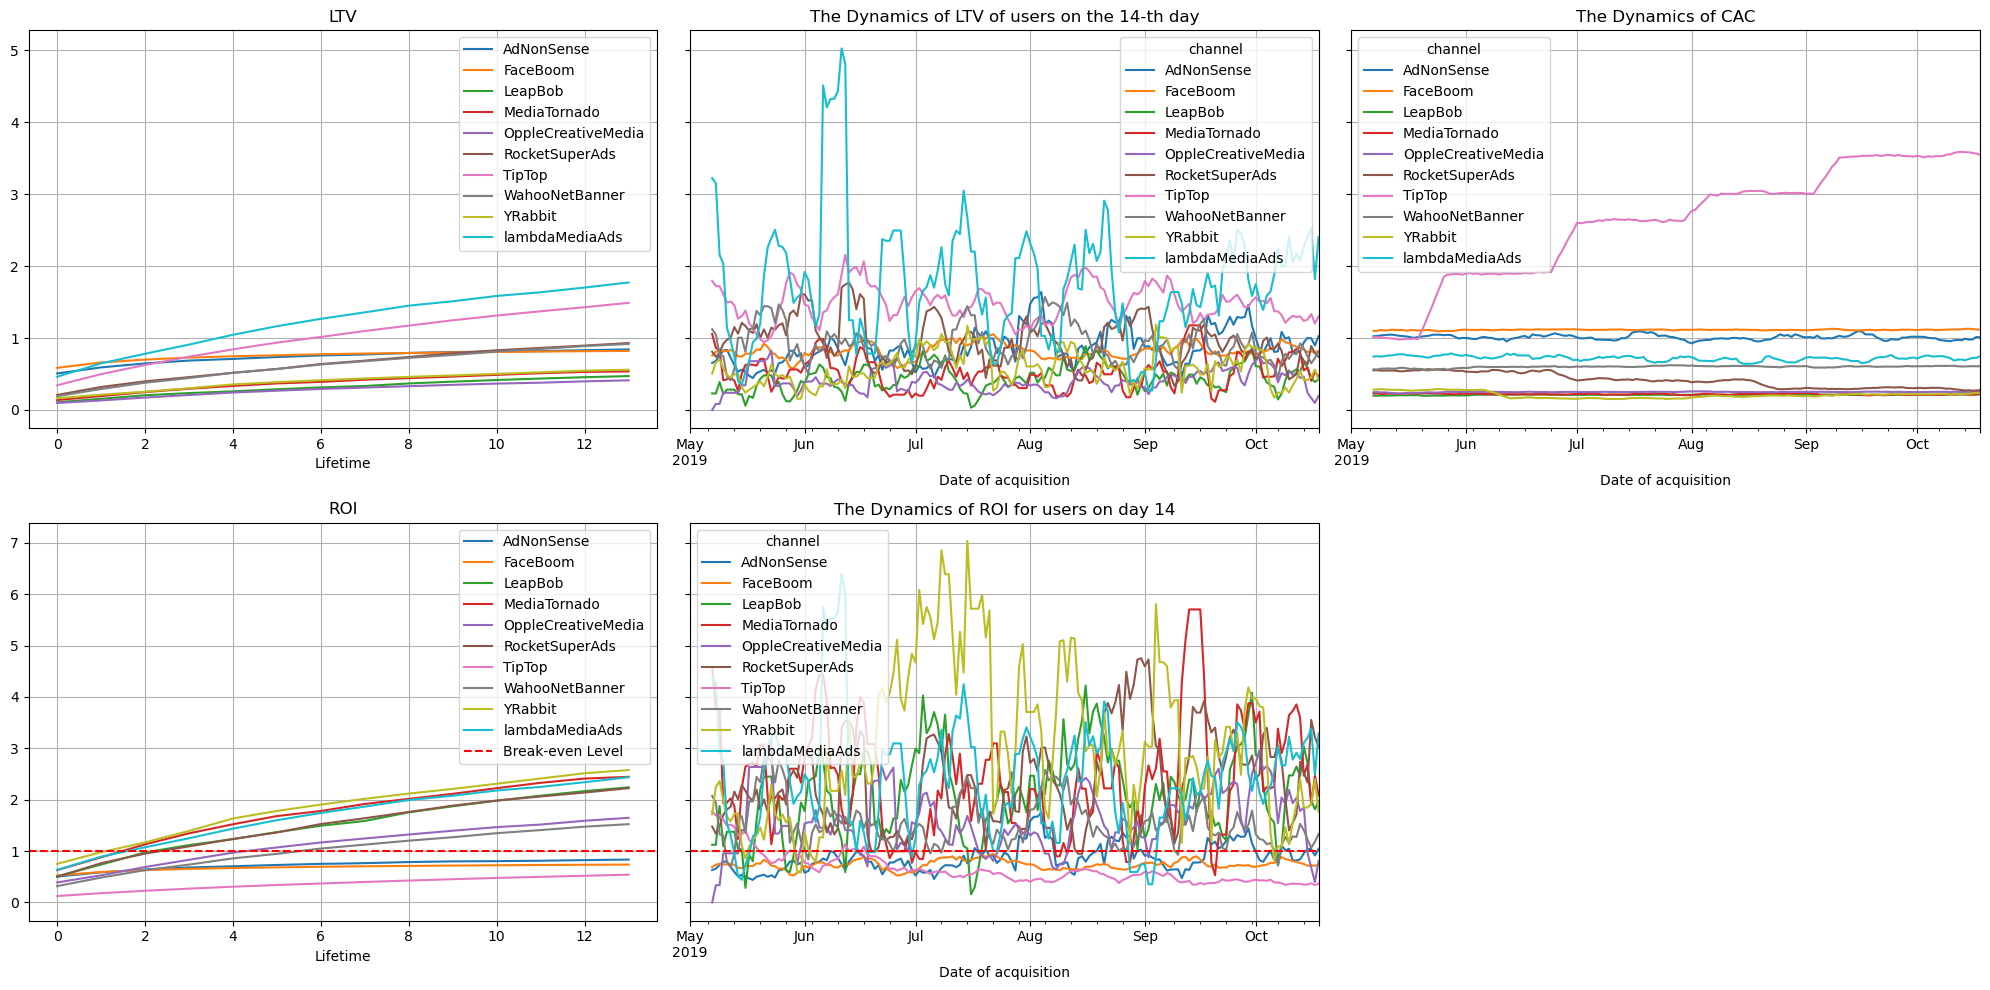

In [53]:
# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_non_org_usa, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'],)

    
# bulding of graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

Advertising ROI analysis with breakdown by advertising channels once again confirmed that advertising on AdNonSense, FaceBoom, and TipTop channels was effective both during the analysis period and throughout the entire period for which information is provided. If expenses were distributed evenly across other advertising channels, then advertising campaigns on the TipTop channel with significant and steadily increasing budgets did not justify themselves. In order to increase the effectiveness of advertising expenses on the TopTop advertising channel, one can consider advertising on channels such as lambdaMediaAds, MediaTornado, YRabbit, which show positive results with a small budget.

## 4. Conclusions

Despite significant investments in advertising, the company has been incurring losses for the past few months, especially from the entertainment application Procrastinate Pro+. The project's task is to understand the reasons for the current situation based on data about users attracted from May 1st to October 27th, 2019.

Profiles of 150,008 users from France, Germany, the United Kingdom, and the USA have been created, and the analysis of these profiles has led to the following conclusions. The application is most popular in the USA, where it has the largest number of paying users both in absolute and relative terms: 6,902 people, which constitutes 6.9% of the total number of users in the USA. The devices preferred by all customers and the devices preferred by paying customers are 'Android,' 'iPhone,' 'Mac,' and 'PC.' Among paying users, Mac and iPhone are the most popular (6.36% and 6.21% of the total number of users, respectively).

The channels that have the highest share of paying users are Faceboom, AdNonSense, and LambdaMediaAds, accounting for 12.20%, 11.34%, and 10.47% of the total number of users in these channels, respectively. However, the leaders among the channels in terms of the number of users are Organic, FaceBoom, and TipTop.

The total marketing expenses amount to 105,497.3. The main advertising sources are TipTop with 54,751.30 and FaceBoom with 32,445.60. The rest of the marketing expenses are distributed among 6 other sources. Speaking of the dynamics of expenses, different advertising campaign strategies have been chosen for TipTop and FaceBoom. For the FaceBoom channel, advertising expenses are evenly distributed from 1000 to 2000 weekly. For the TipTop channel, a different strategy of advertising campaigns was chosen, with expenses increasing and reaching a maximum in September.

The highest average cost of acquiring one user (CAC) is associated with the TipTop source, which amounts to 2.80. FaceBoom and AdNonSense sources rank second and third in terms of CAC (1.11 and 1.01, respectively). Through the TipTop source, 1,878 paying users were acquired, while FaceBoom and AdNonSense sources attracted 3,557 and 440 paying users, respectively.

It's worth noting the organic source, which attracted customers without incurring advertising expenses. However, the number of its paying users reached 1,160. Users from the Organic source were not included in the analysis, as their acquisition was done without advertising expenses.

Thus, when identifying the reasons for the low effectiveness of advertising expenses, it is necessary to pay attention to the TipTop and AdNonSense channels.

Analysis of advertising profitability. The analysis moment is November 1, 2019. The analysis horizon is two weeks after attracting the user, as this period is set in the business plan as the payback period.

Overall, the analysis of indicators for profiles of paying users allowed the following conclusions: 

1. The cumulative revenue constantly grew during the analysis horizon; 

2. The cumulative revenue remained roughly at the same level throughout the entire period; 

3. CAC increased throughout the entire period; 

4. ROI did not reach profitability levels throughout the period; 

5. The overall ROI trend showed a tendency to decrease, and by June, advertising expenses stopped paying off.

The analysis of the user conversion revealed that conversion does not depend on the date of the first user visit or on the devices they use. Users who own Mac and iPhone have higher conversion rates than other users. Users from the USA are significantly outperforming other users as the highest conversion rates shows. The graph of advertising sources shows that the maximum conversion rate is reached in the second week and then stabilizes at a certain level. The channels FaceBoom, adNonSense, and LambdaMediaAds show the highest conversion rates.

Charts of the user retention show that the lowest retention rate is consistently demonstrated by the advertising channel 'FaceBoom.' The relatively low level of retention among US users reflects the high market competition and the population's high financial capacity.

Revenues from users in the United States were growing at a faster pace than from users in other countries. However, advertising expenses to attract them had higher growth rates and did not pay off in the short or long term. Advertising expenses in other countries began to pay off after 6 days of the user's first visit and showed good profitability in the long term. The U.S. market is the largest and most financially capable, but as mentioned above, it faces stiff competition and low margins. A more thorough analysis is needed to study the further prospects for promoting the application in the U.S. or to focus on other countries.

Over the analyzed period, the revenues generated by users had a growth trend regardless of the devices they used. However, the cost of acquiring users also increased, with users of Mac and iPhone devices increasing at higher rates compared to other devices. For PC users, the cost of acquiring them was significantly lower, and the return on investment was higher than for other devices. It can be said that only advertising expenses targeting PC users paid off. Therefore, it is considered necessary to draw the attention of marketers to the segment of users who access the application via PC.

The analysis of advertising profitability broken down by advertising channels once again confirmed that advertising on AdNonSense, FaceBoom, and TipTop channels was unprofitable both during the analysis horizon and throughout the entire period for which information is provided. If expenses for other advertising channels were distributed evenly, then advertising campaigns on the TipTop channel, with significant and constantly increasing budgets, did not justify themselves. In order to increase the efficiency of advertising expenses on the TipTop advertising channel, you can consider advertising on channels like lambdaMediaAds, MediaTornado, and YRabbit, which show positive results with a small budget.